In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os


data_dir = '/content/drive/MyDrive/dataset/dataset'
os.listdir(data_dir)



['test', 'train']

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
data_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x])
                  for x in ['train', 'test']}
data_loader = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
               for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(class_names)

['rawmango', 'ripemango']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, len(class_names))  # Update to match number of classes

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)
def calculate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 39.7MB/s]


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
test_accuracies = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in data_loader['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    train_accuracy = calculate_accuracy(data_loader['train'])
    test_accuracy = calculate_accuracy(data_loader['test'])
    epoch_loss = running_loss / len(image_datasets['train'])

    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Loss: 0.0999, Train Accuracy: 0.9903, Test Accuracy: 0.6180
Epoch 2/10, Loss: 0.0719, Train Accuracy: 0.9942, Test Accuracy: 0.5080
Epoch 3/10, Loss: 0.0510, Train Accuracy: 0.9948, Test Accuracy: 0.5560
Epoch 4/10, Loss: 0.0326, Train Accuracy: 0.9974, Test Accuracy: 0.6280
Epoch 5/10, Loss: 0.0251, Train Accuracy: 0.9974, Test Accuracy: 0.5000
Epoch 6/10, Loss: 0.0483, Train Accuracy: 0.9961, Test Accuracy: 0.6240
Epoch 7/10, Loss: 0.0131, Train Accuracy: 0.9994, Test Accuracy: 0.6080
Epoch 8/10, Loss: 0.0303, Train Accuracy: 0.9942, Test Accuracy: 0.5100
Epoch 9/10, Loss: 0.0374, Train Accuracy: 0.9948, Test Accuracy: 0.5360
Epoch 10/10, Loss: 0.0091, Train Accuracy: 0.9994, Test Accuracy: 0.5080


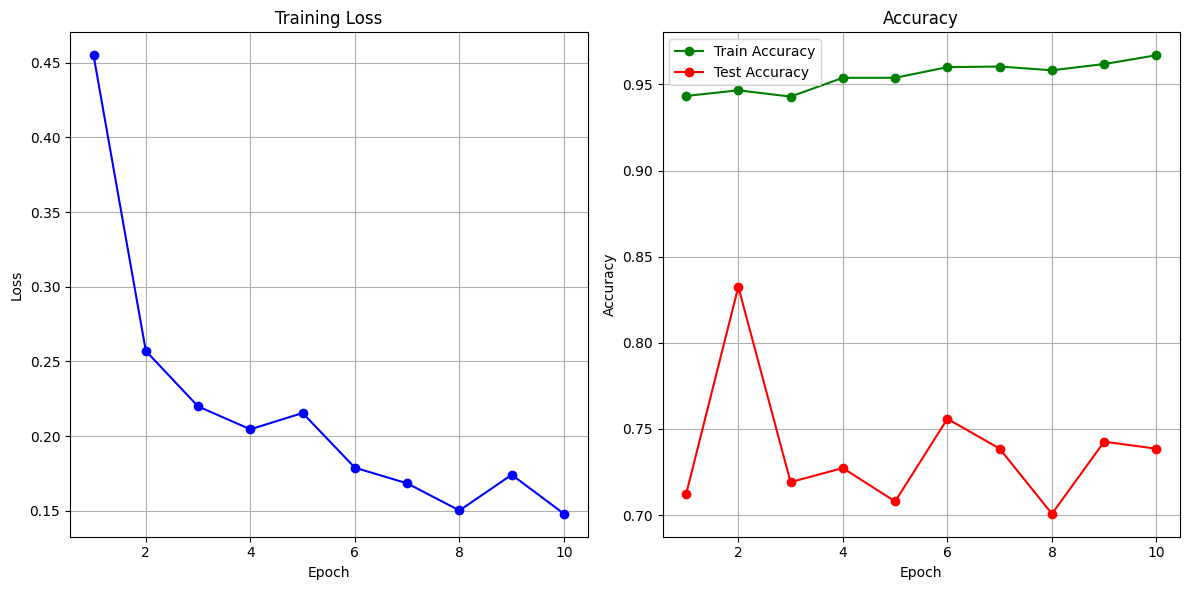

In [ ]:
# Plot Loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', color='g', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', color='r', label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


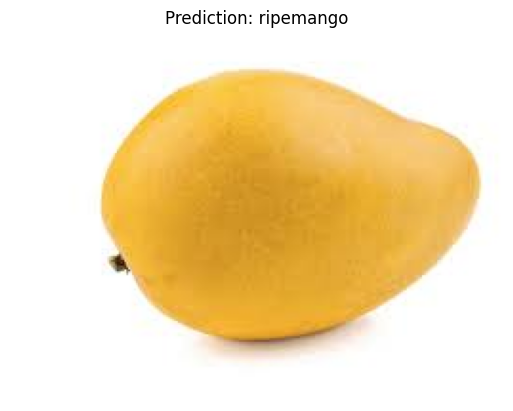

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
def predict_image(image_path):
    image = Image.open(image_path)
    image_tensor = data_transform['test'](image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor.to(device)

    model.eval()
    with torch.no_grad():
        output = model(input)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Prediction: {predicted_class}')
    plt.show()

def get_latest_file(directory):
    # List all files in the directory
    files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    # Check if directory is empty
    if not files:
        return None

    # Find the most recently modified file
    latest_file = max(files, key=os.path.getmtime)

    return latest_file
# Updated image path
add_path = "/content/drive/MyDrive/new_images"
full_apth = os.path.join(data_dir,add_path)
image_path = get_latest_file(add_path)
predict_image(image_path)